In [1]:
import sys
import os
import time
import json
import numpy as np
import scipy as sp
import pandas as pd
from scipy.stats import kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
from scipy.spatial.distance import cdist, pdist
from operator import itemgetter
from itertools import chain
from collections import Counter
from pyemd import emd_samples
from src.lexrank import degree_centrality_scores
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.parsing.preprocessing import preprocess_documents

import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from config import *

from typing import Callable

## Extractive Summarization by Maximizing Semantic Volume

Paper: https://www.aclweb.org/anthology/D15-1228.pdf

In [2]:
def distance_to_subspace(v: np.array, S: np.array) -> float:
    '''Calculates a distance from vector to subspace'''
    return np.linalg.norm(v - (v @ S.T) @ S)

In [3]:
def max_semantic_volume_summary(R: np.array, L: int, dist: Callable) -> list:
    '''Implementation of the "Extractive Summarization by Maximizing Semantic Volume".
    
    Note: The budget constraint is number of sentences in summary, not the number of words.
    
    :param R:    Sentence reprezentations
    :param L:    Number of sentences in summary
    :param dist: Function that computes distance to subspace
    
    :return: Sentence indices
    '''
    N = R.shape[0]

    B = np.ndarray(shape=(0,R.shape[1]))
    idx = []

    c = R.sum(axis=0) / N

    p = np.argmax(np.linalg.norm(R - c, axis=1))
    idx.append(p)

    q = np.argmax(np.linalg.norm(R - R[p], axis=1))
    idx.append(q)

    b_0 = R[q] / np.linalg.norm(R[q])
    B = np.append(B, b_0.reshape(1,-1), axis=0)

    for i in range(L-2):
        d = np.apply_along_axis(dist, 1, R, B)
        r = np.argmax(np.ma.masked_array(d, mask=np.in1d(range(N),idx))) # mask the indices already chosen
        idx.append(r)

        b_r = R[r] / np.linalg.norm(R[r])
        B = np.append(B, b_r.reshape(1,-1), axis=0)
        
    return idx

### Misc

In [4]:
def load_data(dataset, encoded):
    ext = '_encoded.json' if encoded else '.json'
    with open(os.path.join(DATA_DIR, dataset + ext), mode='r') as fp:
        return json.load(fp)
    
def extract(topic):
    documents = np.array(list(chain(*topic['documents'])))
    annotations = topic['annotations']

    summaries_tmp = list(map(itemgetter('text'), annotations))
    indices_tmp = np.cumsum([0] + list(map(len, summaries_tmp)))
    summaries = np.array(list(chain(*summaries_tmp)))
    indices = np.array(list(zip(indices_tmp[:-1], indices_tmp[1:])))
    
    pyr_scores = np.array(list(map(itemgetter('pyr_score'), annotations)))
    
    return documents, summaries, indices, pyr_scores

def calculate_scores(indices, metric):
    return np.array([metric(i) for i in indices])

### Visualization

In [5]:
def make_pytorch_projector(log_dir, embeddings, global_step):
    '''Exports PyTorch projector'''
    writer = SummaryWriter(log_dir)
    writer.add_embedding(embeddings['mat'],
                         metadata=embeddings['labels'],
                         tag=embeddings['tag'],
                         global_step=global_step)
    writer.close()

def project_pca(embs, t):
    pca = PCA(n_components=2, random_state=42)
    pts = pca.fit_transform(embs)
    return pts[:t], pts[t:]

def project_tsne(embs, t):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=5000, verbose=1, random_state=42)
    pts = tsne.fit_transform(embs)
    return pts[:t], pts[t:]
    
def plot(proj, ax, title, document_pts, summary_pts):
    def plot_pts(pts, c, alpha):
        ax.scatter(pts[:,0], pts[:,1], c=c, alpha=alpha)
        hull = ConvexHull(pts)
        idx = np.concatenate((hull.vertices, hull.vertices[:1]))
        ax.plot(pts[idx,0], pts[idx,1], c=c, linestyle='dashed', lw=2)

    plot_pts(document_pts, c='tab:blue', alpha=0.15)
    plot_pts(summary_pts, c='tab:red', alpha=0.5)

    ax.set_title(title)
    ax.set_xlabel(f'{proj}-0')
    ax.set_ylabel(f'{proj}-1')

### Redundancy Metrics

In [6]:
def number_of_sentences(summary):
    '''Counts the number of sentences in a summary'''
    return len(summary)

def repeating_words(summary):
    '''Counts the number of repeating words in a summary'''
    cnt = Counter(chain(*preprocess_documents(summary)))
    return len([cnt[k] for k in cnt if cnt[k] > 1])

def average_pairwise_distance(summary_embs: np.array) -> float:
    '''Calculates the average pairwise distance between summary embeddings'''
    return np.mean(cdist(summary_embs, summary_embs, metric='euclidean'))

def semantic_volume(summary_embs: np.array) -> float:
    '''Calculates the semantic volume of the summary embeddings'''
    try:
        return ConvexHull(summary_embs).volume
    except QhullError as e:
        return 0

def semantic_spread(summary_embs: np.array) -> float:
    '''Calculates the semantic spread of the summary embeddings'''
    return np.linalg.det(summary_embs @ summary_embs.T)

### Relevance Metrics

In [7]:
def earth_mover_distance(document_embs: np.array, summary_embs: np.array) -> float:
    '''Calculates the Earth Mover distance between the document and summary distributions.'''
    return emd_samples(document_embs, summary_embs)

def lex_rank(document_embs: np.array, summary_embs: np.array, lr_scores: np.array) -> float:
    '''Calculates the LexRank score of the summary based on the documents LexRank score.'''
    return np.sum(lr_scores[np.argmax(cdist(summary_embs, document_embs, metric='cosine'), axis=1)])

# Introduction

Use-case:
1. Take the documents, summaries, and pyramid scores
2. Embed the documents and summaries (or load embeddings)
3. Calculate score for summaries
4. Compute correlation with human judgements
5. Plot

In [8]:
DATASET = DATASETS[0]
TOPIC = TOPICS[DATASET][0]

# Scores

In [9]:
def execute_experiment(tac, experiment):
    scores = []

    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores = extract(topic)
        scores.append(experiment(document_embs, summary_embs, indices, pyr_scores))
    
    return np.array(scores)

In [10]:
def experiment_number_of_sentences(documents, summaries, indices, pyr_scores):
    metric = lambda i: number_of_sentences(summaries[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_repeating_words(documents, summaries, indices, pyr_scores):
    metric = lambda i: repeating_words(summaries[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_average_pairwise_distance(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: average_pairwise_distance(summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_semantic_volume(document_embs, summary_embs, indices, pyr_scores):
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(summary_pts[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_semantic_spread(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_earth_mover_distance(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: earth_mover_distance(document_embs, summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_lex_rank(document_embs, summary_embs, indices, pyr_scores):
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

In [11]:
tac = load_data(DATASET, encoded=True)

In [12]:
print('=== Experiments ===\n')
s = ''

print('   Executing "Average pairwise distance"')
scores_1 = execute_experiment(tac, experiment_average_pairwise_distance)
s += f'   Average pairwise distance:       {np.mean(scores_1):.6f}\n'

print('   Executing "Semantic volume"')
scores_2 = execute_experiment(tac, experiment_semantic_volume)
s += f'   Semantic volume:                 {np.mean(scores_2):.6f}\n'

print('   Executing "Semantic spread"')
scores_3 = execute_experiment(tac, experiment_semantic_spread)
s += f'   Semantic spread:                 {np.mean(scores_3):.6f}\n'

# print('   Executing "Earth Mover distance"')
# scores_4 = execute_experiment(tac, experiment_earth_mover_distance)
# s += f'   Earth Mover distance:            {np.mean(scores_4):.6f}\n'

print('   Executing "LexRank"')
scores_5 = execute_experiment(tac, experiment_lex_rank)
s += f'   LexRank:                         {np.mean(scores_5):.6f}\n'

print('\n=== Results ===\n')
print(s)

=== Experiments ===

   Executing "Average pairwise distance"
   Executing "Semantic volume"
   Executing "Semantic spread"
   Executing "LexRank"

=== Results ===

   Average pairwise distance:       -0.015680
   Semantic volume:                 0.040874
   Semantic spread:                 0.025482
   LexRank:                         0.061911



## Plot Kendall correlation scores accross topics

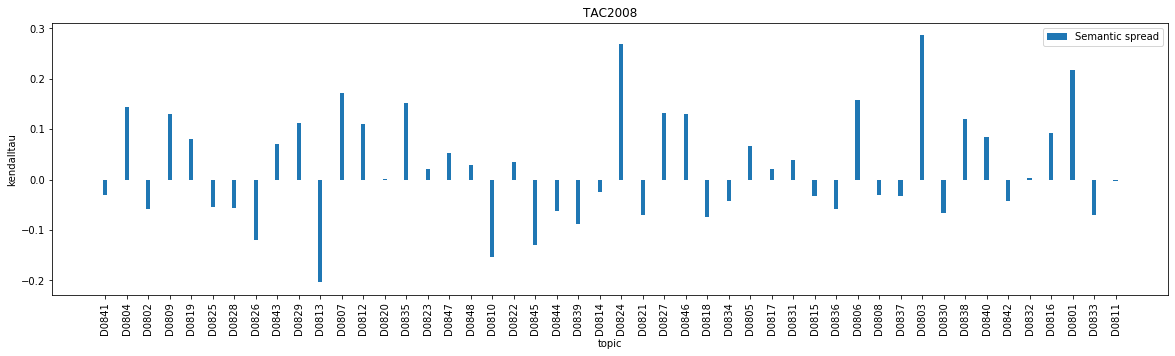

In [13]:
topics = list(tac.keys())
x = np.arange(len(topics))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
ax.bar(x, scores_3, width=0.2, label='Semantic spread')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=90)
ax.set_title(DATASET)
ax.set_xlabel('topic')
ax.set_ylabel('kendalltau')
ax.legend()
plt.show()

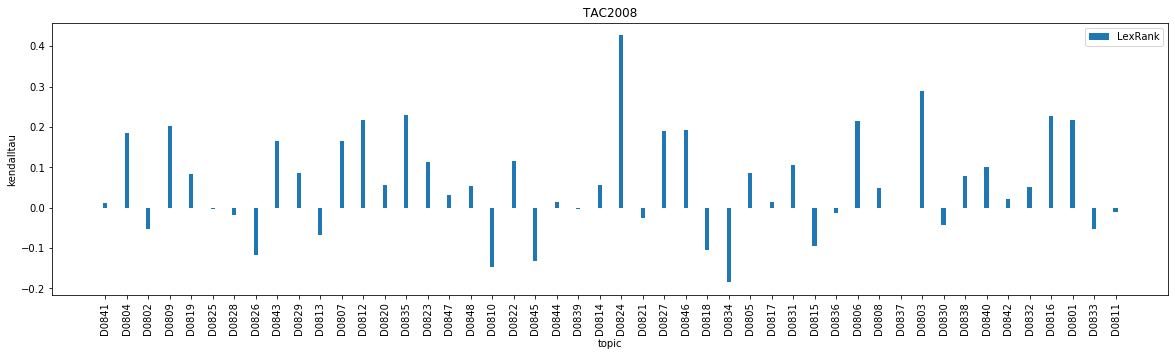

In [14]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.bar(x, scores_4, width=0.2, label='Earth Mover distance')
ax.bar(x, scores_5, width=0.2, label='LexRank')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=90)
ax.set_title(DATASET)
ax.set_xlabel('topic')
ax.set_ylabel('kendalltau')
ax.legend()
plt.show()

## Experimental

### Combination of Relevance and Redundancy metrics

In [15]:
for alpha in np.linspace(0,1,10):

    def experiment_comb(document_embs, summary_embs, indices, pyr_scores):
        metric_1 = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
        scores_1 = calculate_scores(indices, metric_1)

        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
        metric_2 = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
        scores_2 = calculate_scores(indices, metric_2)

        scores = (1-alpha) * scores_1 + alpha * scores_2

        return kendalltau(pyr_scores, scores)[0]

    print(np.mean(execute_experiment(tac, experiment_comb)))

0.025482417090920906
0.025436683661036918
0.025436683661036918
0.025436683661036918
0.025413813902452075
0.025413813902452075
0.025413813902452075
0.025413813902452075
0.02545903980889087
0.061910791288954686


### Regression analysis on metrics

In [16]:
import pandas as pd

data = []

for topic_id, topic in tac.items():
    document_embs, summary_embs, indices, pyr_scores = extract(topic)
        
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))

    for p,i in enumerate(indices):
        data.append({
            'topic': topic_id,
            'red_1': average_pairwise_distance(summary_embs[i[0]:i[1]]),
            'red_2': semantic_volume(summary_pts[i[0]:i[1]]),
            'red_3': semantic_spread(summary_embs[i[0]:i[1]]),
            'rel_1': lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores),
            'y': pyr_scores[p]
        })

df = pd.DataFrame(data)

In [17]:
df.corr(method='kendall')

,red_1,red_2,red_3,rel_1,y
red_1,1.000000,0.631024,0.802698,0.548021,-0.038954
red_2,0.631024,1.000000,0.600693,0.471798,0.021169
red_3,0.802698,0.600693,1.000000,0.660558,-0.004614
rel_1,0.548021,0.471798,0.660558,1.000000,0.041287
y,-0.038954,0.021169,-0.004614,0.041287,1.000000


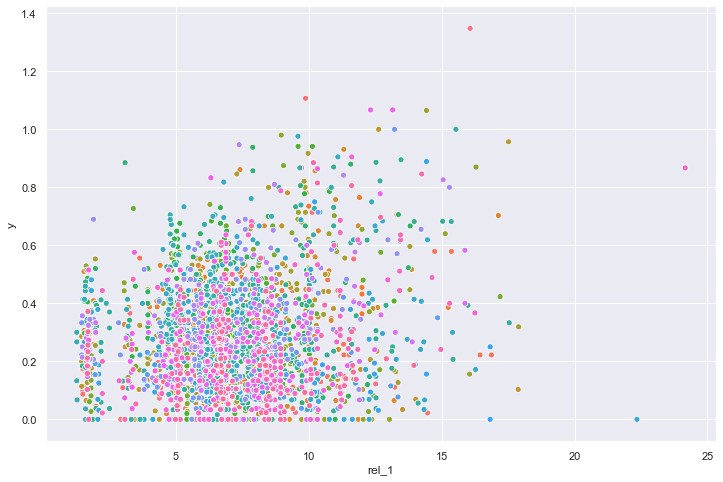

In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

topics = df.topic.unique()

sns.scatterplot('rel_1', 'y', data=df, hue='topic', legend=False);

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:-1], df.iloc[:,-1], stratify=df.iloc[:,0])

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

estimator = Ridge()

parameters = { 'alpha': np.linspace(0, 1, 100) }

cv = GridSearchCV(estimator, parameters, scoring='neg_mean_squared_error', cv=10)

cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

{'alpha': 0.5353535353535354}
-0.0324857973970756


In [21]:
best_estimator = cv.best_estimator_
best_estimator.score(X_test, y_test)

0.04681741074692003

### Exporting best summaries for all datasets

In [19]:
for DATASET in DATASETS:
    tac = load_data(DATASET, encoded=True)
    print(f'Loaded {DATASET}')
    
    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores = extract(topic)

        m = np.argsort(-pyr_scores)

        embeddings = {
            'tag': f'{DATASET}:{topic_id}:System Summaries:BERT',
            'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
            'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
        }

        make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))
        print(f'Exported {topic_id}')

# Plotting BERT

In [70]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

## System Summaries

### TensorBoard

In [12]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:System Summaries:BERT',
    'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
    'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

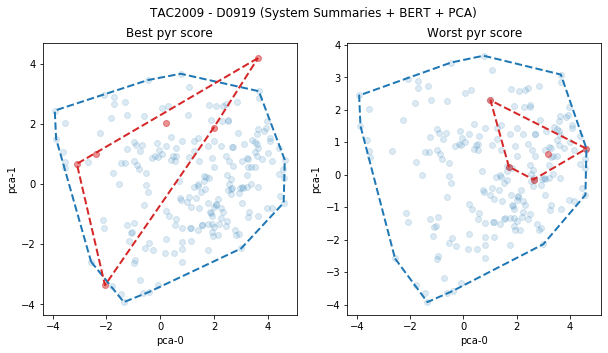

In [13]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 473 samples in 0.015s...
[t-SNE] Computed neighbors for 473 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 473 / 473
[t-SNE] Mean sigma: 2.878953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.332146
[t-SNE] KL divergence after 2400 iterations: 0.672893


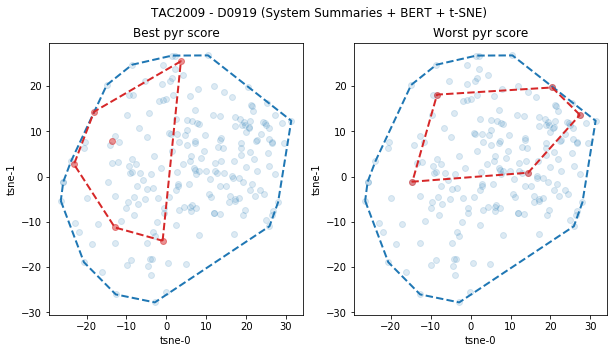

In [14]:
document_pts, summary_pts = project_tsne(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

## Extractive Summarization by Maximizing Semantic Volume

In [15]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [16]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:BERT',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

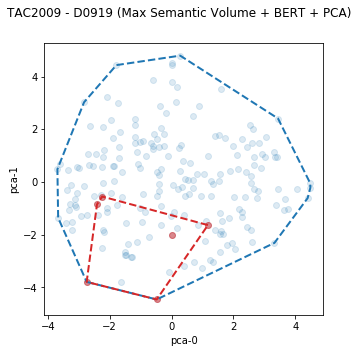

In [17]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.004s...
[t-SNE] Computed neighbors for 208 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 2.745973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.173157
[t-SNE] KL divergence after 1050 iterations: 0.777134


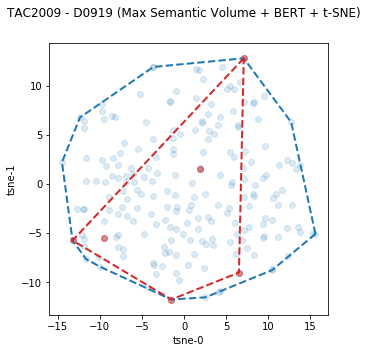

In [18]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Plotting SVD

In [19]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=True)
X = vectorizer.fit_transform(documents)

# If bigram b is present in s_i,
# we let s_i,b be the number of documents
# in the corpus that contain bigram b, and
# zero otherwise.
nd = X.sum(axis=0)
S = X.multiply(nd)

### Decompose
U, Sigma, VT = randomized_svd(S, n_components=100, n_iter=5, random_state=42)

# We then perform singular value decomposition (SVD)
# on S. We use U_K as the sentence representations.

In [21]:
document_embs = U

## Extractive Summarization by Maximizing Semantic Volume

In [22]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [23]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:SVD',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

###  PCA

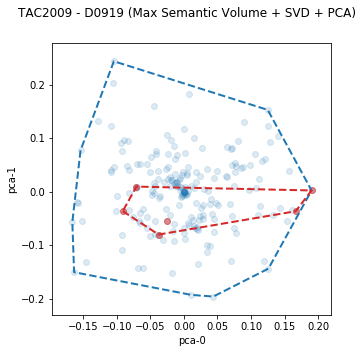

In [24]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.001s...
[t-SNE] Computed neighbors for 208 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.240379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.293152
[t-SNE] KL divergence after 1400 iterations: 1.076915


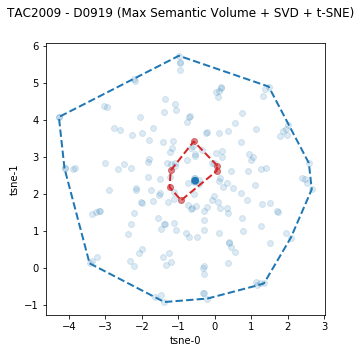

In [25]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Interactive plot BERT

In [26]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

### PCA

In [27]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[indices[m[i],0]:indices[m[i],1]], f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [28]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…